## EDA on Credit Card Spending

### Imports

In [35]:
# necessary imports
import pandas as pd
from matplotlib import pyplot as plt

### EDA

**Note**:

I did some preliminary preprocessing on data from Bank of America prior to importing it into this notebook. Upon raw export, BoA data did not contain sale type, but more importantly it didn't have a category. Thus, I followed the same category definition as that of Chase Bank spending data. Since there weren't that many records, I manually inputted them.

I start by reading in all `.csv` files from Bank of America, Chase, and Apple to take a peek at the data.

In [36]:
# Read in the datasets
boa_csv = "data/bofa_spending_mod.csv"
boa_df = pd.read_csv(boa_csv)

chase_csv = "data/chase_spending.csv"
chase_df = pd.read_csv(chase_csv)

apple_csv = "data/apple_spending.csv"
apple_df = pd.read_csv(apple_csv)

#### Bank of America (BoA)

In [37]:
# Bank of America (BoA)
boa_df.head(10)

,Posted Date,Reference Number,Payee,Address,Category,Type,Amount
0,05/09/2023,24013393128000843027542,GALPAO GAUCHO CUPERTINO,CUPERTINO CA,Food & Drink,Sale,-175.44
1,05/04/2023,12483204320050400050016,PAYMENT - THANK YOU,NaN,NaN,Payment,1789.32
2,04/28/2023,24137463117100440204356,TST* TEASPOON - SARATOGA,SAN JOSE CA,Food & Drink,Sale,-5.50
3,04/25/2023,24431063115091711000198,CHIPOTLE 1031,NEWARK CA,Food & Drink,Sale,-24.53
4,04/24/2023,24431063114091710000737,CHIPOTLE 1031,NEWARK CA,Food & Drink,Sale,-13.84
5,04/24/2023,24765013113200000000982,DINO'S RESTAURANT,FREMONT CA,Food & Drink,Sale,-38.00
6,04/24/2023,24445003113000830662095,CKE*IKES PLACE PALO ALTO,PALO ALTO CA,Food & Drink,Sale,-36.33
7,04/24/2023,24435653113091072000619,IKEA EAST PALO ALTO,PALO ALTO CA,Shopping,Sale,-7.81
8,04/24/2023,24435653113091585000536,IKEA EAST PALO ALTO,PALO ALTO CA,Shopping,Sale,-313.13
9,04/24/2023,24323043112040300073195,DINOS GRILL,NEWARK CA,Food & Drink,Sale,-33.03


To quickly define each feature:

* **Posted Date**: The date when the transaction is recieved to my account
* **Reference Number**: A unique identifier for the transaction
* **Payee**: Merchant I bought from
* **Address**: Self-explanatory
* **Category**: Label used to categorize a transaction
* **Type**: Either a *Sale* made to a merchant or a *Payment* made to the bank
* **Amount**: Self-explanatory

##### Null Values

From just looking at the `.head` of the data, there appears to be some null (`NaN`) values in features `Address` and `Category`. Taking a closer look at these records with nulls:


In [38]:
# Looking at records with null values in the Address feature
boa_df[boa_df['Address'].isna()]

,Posted Date,Reference Number,Payee,Address,Category,Type,Amount
1,05/04/2023,12483204320050400050016,PAYMENT - THANK YOU,NaN,NaN,Payment,1789.32


It seems like there are only *two* null values in the entire BoA DataFrame. I want to confirm this and I will probably have to do the same check on the other two DataFrames, Chase and Apple. Thus, below, I define a helper function that returns the amount of null values in a DataFrame.

In [39]:
# Helper function that counts the number of null (NaN) values in a DataFrame.
# Takes in a DataFrame `df` and returns the number of null values.
# If a name is passed into `df_name`, then a message will be printed.
def count_null(df, df_name = ""):
    num_null = sum(sum(df.isna().values))
    if df_name:
        print("{} contains {} null value(s)".format(df_name, num_null))
    return num_null

Confirming the number of null values to be $2$ in `bofa_df`:

In [40]:
# Call helper function on BoA DataFrame
boa_nulls = count_null(boa_df, 'BoA')

BoA contains 2 null value(s)


Helper function seems to be working as intended for now.

As for the null values, it seems like it occurs when a credit card payment is being made. This makes sense as there are no `Address` or `Category` for a credit card payment, no item is being bought from a merchant. Since I plan on analyzing my spending, these payment records are not needed; I plan on removing them during pre-processing.

##### `Amount`

Looking at the `Amount` column, other than records of `Type` "Payment," it appears to all be in the negatives. To confirm this, I take a look at the distribution of values in `Amount`:

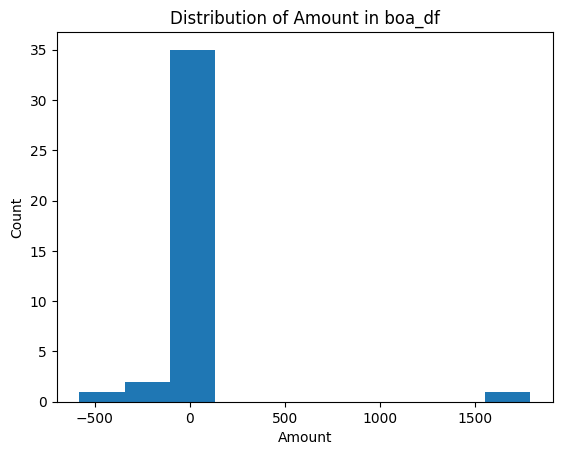

In [41]:
# Plotting the distribution of `Amount` in `boa_df`
plt.hist(boa_df['Amount'])
plt.title('Distribution of Amount in boa_df')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

From looking at the distribution, it does appear that all records other than payments are negative. To confirm this for sure, I count the number of records where `Amount` is $\leq 0$ and compare it to the total number of records in `boa_df`:

In [42]:
# BoA records with Amount <= 0
print("boa_df negative records: {}".format(len(boa_df[boa_df['Amount'] <= 0])))

# BoA total records
print("boa_df total records: {}".format(len(boa_df)))

boa_df negative records: 38
boa_df total records: 39


This confirms that records with `Type` "Payment" are the only positive transactions. In my analysis, I would prefer to work with positive numbers. Thus, I will be converting these negative amounts to positive in preprocessing.

#### Chase

In [43]:
# Chase
chase_df.head(10)

,Transaction Date,Post Date,Description,Category,Type,Amount,Memo
0,05/25/2023,05/26/2023,Kindle Svcs*O67RM7PS3,Shopping,Sale,-9.99,NaN
1,05/19/2023,05/21/2023,Payment Thank You-Mobile,NaN,Payment,24.98,NaN
2,05/12/2023,05/14/2023,Netflix,Bills & Utilities,Sale,-19.99,NaN
3,05/11/2023,05/12/2023,Spotify USA,Bills & Utilities,Sale,-4.99,NaN
4,05/05/2023,05/05/2023,Payment Thank You - Web,NaN,Payment,220.63,NaN
5,05/03/2023,05/04/2023,PAYPAL *STEAM GAMES,Entertainment,Sale,-29.22,NaN
6,05/02/2023,05/02/2023,PAYPAL *STEAM GAMES,Entertainment,Sale,-19.99,NaN
7,04/30/2023,05/02/2023,IZUMI SUSHI,Food & Drink,Sale,-154.95,NaN
8,04/30/2023,05/02/2023,BERKELEY BOWL WEST,Groceries,Sale,-5.99,NaN
9,04/29/2023,04/30/2023,PAYPAL *GWDCONCEPTS,Shopping,Sale,-10.48,NaN


Similar to what I did to the BoA data, I want to take a look at records that contain null values in the `Category` column to confirm wehther or not those are of `Type` "Payment."

In [44]:
chase_df[chase_df['Category'].isna()]

,Transaction Date,Post Date,Description,Category,Type,Amount,Memo
1,05/19/2023,05/21/2023,Payment Thank You-Mobile,NaN,Payment,24.98,NaN
4,05/05/2023,05/05/2023,Payment Thank You - Web,NaN,Payment,220.63,NaN
10,04/17/2023,04/18/2023,Payment Thank You-Mobile,NaN,Payment,99.43,NaN
15,04/10/2023,04/10/2023,Payment Thank You - Web,NaN,Payment,778.30,NaN
26,03/29/2023,03/29/2023,Payment Thank You - Web,NaN,Payment,637.64,NaN
33,03/20/2023,03/20/2023,Payment Thank You-Mobile,NaN,Payment,18.22,NaN
38,03/16/2023,03/16/2023,Payment Thank You - Web,NaN,Payment,656.60,NaN
48,03/05/2023,03/05/2023,Payment Thank You - Web,NaN,Payment,434.22,NaN
61,02/20/2023,02/20/2023,Payment Thank You-Mobile,NaN,Payment,683.69,NaN
84,01/30/2023,01/30/2023,Payment Thank You - Web,NaN,Payment,667.23,NaN


As suspected, they are of `Type` "Payment." During preprocessing, these records will be removed. As a side note, I found it pretty interesting that Chase kept track of how I made my payment, either through their website or through their mobile application.

There are a total of $11$ payment records, but there also seems to be an additional `Memo` column that contains null values. Taking a look at the values in this column:

In [45]:
chase_df['Memo'].unique()

array([nan])

`Memo` in `chase_df` seems to only contain null values, which makes sense as I don't ever recall making a memo or publishing comments on my purchases. Thus, this column will be removed in preprocessing as it adds no information.

My `count_null()` helper function counts the number of null values in a DataFrame, and thus this check wouldn't work properly unless the column was removed. Thus, I will temporarily drop the column to check null values in `chase_df`. With the previously mentioned $11$ payment records, `count_null()` should return $11$ with the `Memo` column dropped in `chase_df`.

In [46]:
# Checking null values in the entire `chase_df` without the `Memo` column
chase_nulls = count_null(chase_df.drop(['Memo'], axis=1), 'Chase')

Chase contains 11 null value(s)


As predicted, only records with `Type` "Payment" conteain null values in the `Category` column. Thus, just like what I did for the Bank of America data, these records will be removed in preprocessing.

And just like `boa_df`, the `Amount` column in `chase_df` also seems to be *positive* for "Payment" and *negative* for "Sales." I confirm this below:

In [47]:
# Chase records with Amount <= 0
print("chase_df negative records: {}".format(len(chase_df[chase_df['Amount'] <= 0])))

# BoA total records
print("chase_df total records: {}".format(len(chase_df)))

chase_df negative records: 104
chase_df total records: 115


$115-104=11$, which confirms the number of "Sale" records. These values in `Amount` will be converted to positive values in preprocessing for further analysis.

#### Apple

In [48]:
# Apple
apple_df.head(10)

,Transaction Date,Clearing Date,Description,Merchant,Category,Type,Amount (USD),Purchased By
0,05/27/2023,05/29/2023,KHAN SHABU SHABU AND B1010 E ELCAMINO REAL SUN...,Khan Shabu Shabu and B,Restaurants,Purchase,96.49,Daniel Huang
1,05/25/2023,05/26/2023,SAFEWAY #1224 5877 JARVIS AVE NEWARK 94560 CA USA,Safeway,Grocery,Purchase,24.22,Daniel Huang
2,05/23/2023,05/25/2023,DINOS GRILL 5855 JARVIS AVE STE A NEWARK 94560...,Dino's Grill,Restaurants,Purchase,39.26,Daniel Huang
3,05/23/2023,05/23/2023,OSAKA MARKETPLACE 46881 WARM SPRINGS BOULE FRE...,Osaka Marketplace,Grocery,Purchase,9.30,Daniel Huang
4,05/19/2023,05/21/2023,MCDONALDS 12056 3000 NEWPARK MALL RD NEWARK 94...,McDonald's,Restaurants,Purchase,9.06,Daniel Huang
5,05/18/2023,05/19/2023,SAFEWAY #1224 5877 JARVIS AVE NEWARK 94560 CA USA,Safeway,Grocery,Purchase,36.43,Daniel Huang
6,05/17/2023,05/18/2023,BEST BUY 000085163090 STEVENS CREEK BVD SAN JO...,Best Buy,Other,Purchase,76.55,Daniel Huang
7,05/16/2023,05/17/2023,HABIT FREMONT #93 Q9143830 PACIFIC COMMONS BL ...,Habit Fremont #93 Q91,Restaurants,Purchase,33.42,Daniel Huang
8,05/12/2023,05/14/2023,MCDONALDS 12056 3000 NEWPARK MALL RD NEWARK 94...,McDonald's,Restaurants,Purchase,10.49,Daniel Huang
9,05/13/2023,05/13/2023,CAL ALUMNI ASSOCIATION1 ALUMNI HOUSE (MEMB) BE...,Cal Alumni Association,Other,Purchase,340.00,Daniel Huang


Apple clearly keeps track of more features compared to BoA and Chase. The `Purchased By` feature intrigued me, as I intially thought who would be making a purchase other than me. But upon some research, it appears that you can add [family members to an Apple Card as a "co-owner,"](https://support.apple.com/en-us/HT212020) granting them access to authorize payments. Thus, it makes sense why Apple would have this column in their data.

I start by first checking for null values.

In [49]:
apple_nulls = count_null(apple_df, 'Apple')

Apple contains 0 null value(s)


No null values recorded, that simplifies preprocessing.

Taking a look at the `Amount (USD)` column, it is equivalent to the `Amount` column of BoA and Chase. However, it seems like Apple lists positive values instead of negative. I double check this in the following code cell:

In [50]:
# Apple records with Amount <= 0
print("apple_df negative records: {}".format(len(apple_df[apple_df['Amount (USD)'] <= 0])))

# BoA total records
print("apple_df total records: {}".format(len(apple_df)))

apple_df negative records: 0
apple_df total records: 18


$0$ negative records out of $18$, which implies all records are strictly positive. Once again, this simplifies my preprocessing as no additional work needs to be done.

#### Table Consolidation Plan

Ultimately, I want to combine all records from `boa_df`, `chase_df`, and `apple_df` together. To do that, the three tables must have the same schema. All three tables have a slighly different schema, thus I propose the following universal schema that I wish to work with:


| column_name | type |
| --- | --- |
| transaction_date | date |
| merchant | varchar |
| category | enum |
| amount | int |
| card | enum|

There will be no primary key column for this table; the default index for each transaction will do for my purposes.

Note that for data type, I used SQL data types. In Python, these data types would be simpler (mostly just Strings). But one day when I plan on migrating the cleaned data into a SQL server, this is the schema that I would use.

Below, I define a table showing where in the three DataFrames they will come from:

| column_name | boa_df | chase_df | apple_df |
| --- | --- | --- | --- |
| transaction_date | Posted Date | Transaction Date | Transaction Date |
| merchant | Payee | Description | Merchant |
| category | Category | Category | Category |
| amount | Amount | Amount | Amount (USD) |
| card | "BoA" | "Chase" | "Apple" |

Some things of note:
* The BoA data does not have a transaction date, which is why I use `Posted Date` in its place.
* `Card` column is a feature I will add during preprocessing; it will allow me to group purchases depending on card used, which may be useful for analysis and visualization later on
* `Category` between BoA and Chase are the same (I know this because I feature engineered the Category Column in BoA based on that of Chase), but Apple is different. I will take a look at the unique values in `apple_df` to determine a mapping of Apple's `Category` to the categories shared by BoA and Chase

All other columns that were not enumerated in the schema above will be dropped during preprocessing as they have been determined to not be useful (such as `Memo` in `chase_df`) or would be too hard to replicate in other tables (location comes to mind, don't really want to mess with regex to extrapolate location with all the inconsistencies in merchant description).

#### Investigating Apple's Category Mapping to BoA and Chase

Taking a look at the `Category` column in `apple_df` and `chase_df` (since `boa_df`'s `Category` is based on Chase):

In [51]:
# Chase categories
print("Chase Categories:\n{}\n\n".format(chase_df['Category'].unique()))


# Apple categories
print("Apple Categories:\n{}".format(apple_df['Category'].unique()))

Chase Categories:
['Shopping' nan 'Bills & Utilities' 'Entertainment' 'Food & Drink'
 'Groceries' 'Professional Services' 'Travel' 'Gas']


Apple Categories:
['Restaurants' 'Grocery' 'Other' 'Shopping']


Taking a closer look at the "Other" `Category` in `apple_df`:

In [52]:
apple_df[apple_df['Category']=='Other']

,Transaction Date,Clearing Date,Description,Merchant,Category,Type,Amount (USD),Purchased By
6,05/17/2023,05/18/2023,BEST BUY 000085163090 STEVENS CREEK BVD SAN JO...,Best Buy,Other,Purchase,76.55,Daniel Huang
9,05/13/2023,05/13/2023,CAL ALUMNI ASSOCIATION1 ALUMNI HOUSE (MEMB) BE...,Cal Alumni Association,Other,Purchase,340.00,Daniel Huang


Only $2$ records in `apple_df` are in the "Other" `Category`. With that said, the one from Best Buy should be categorized as "Shopping" and the Cal Alumni Association doesn't really fall into any of Chase's categories, so I think I will have it remain as "Other." I will performer the change on the former in preprocessing.

Without diving to deep into the individual records, it seems like the following mapping can be created for the remaining categories:

| BoA/Chase | Apple |
| --- | --- |
| Shopping | Shopping |
| Food & Drink | Restaurants |
| Groceries | Grocery |

### Preprocessing Plans

As mentioned in earlier sections of the EDA, I will do the following to each individual DataFrame:

* `boa_df`:
    * Drop null records as they are of `Type` "Payment" and I'm only interested in "Sales"
    * Convert `Amount` to positive values
* `chase_df`:
    * Drop null records, same reasoning as above
    * Convert `Amount` to positive values
* `apple_df`:
    * Change record with `Merchant` "Best Buy" with `Category` "Other" to "Shopping"

As for general preprocessing:
* Rename all column names to the corresponding name desired in the table schema:
    * | column_name | boa_df | chase_df | apple_df |
        | --- | --- | --- | --- |
        | transaction_date | Posted Date | Transaction Date | Transaction Date |
        | merchant | Payee | Description | Merchant |
        | category | Category | Category | Category |
        | amount | Amount | Amount | Amount (USD) |
        | card | "BoA" | "Chase" | "Apple" |
* Drop all other columns that are not enumerated in the schema
* For consistency, convert to lower case all values in the `Merchant` column. Additionally get rid of special characters like `*`